# 0. Load Data

In [1]:
import math 
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Isolation Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# VAE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics

In [2]:
df = pd.read_csv("data/cleaned_KPIs.csv")
df.head()

,index,cell_id,DL_TRAFFIC_VOLUME,UL_TRAFFIC_VOLUME,Inter_X2_based_HO_prep,VoLTE_total_traffic,INTRA_FREQ_HO_SR_RATIO,RRC_SR_RATIO,CELL_AVAILABILITY_RATIO,RACH_Stp_Completion_SR_RATIO,...,DCR_LTE_RATIO,CSSR_LTE_RATIO,LTE_INTER_ENODEB_HOSR_RATIO,E_UTRAN_Inter_Freq_HO_SR_RATIO,Inter_RAT_HO_SR_GERAN_SRVCC_RATIO,Inter_RAT_Total_HO_SR_RATIO,E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO,E_RAB_DR_RATIO,HOUR,cell
0,2021-05-09 00:00:00,2.226537e+17,3.779737e+10,3.947172e+09,15.0,4727.0,0.809859,0.992427,1.0,0.962688,...,0.001761,0.996041,0.400000,0.770642,0.963636,0.963636,0.400000,0.001761,0,0
1,2021-05-09 01:00:00,2.226537e+17,3.684898e+10,4.088752e+09,6.0,3076.0,0.886792,0.993288,1.0,0.973207,...,0.002468,0.995465,0.500000,0.842105,1.000000,1.000000,0.500000,0.002468,1,0
2,2021-05-09 02:00:00,2.226537e+17,3.292677e+10,5.016897e+09,8.0,3501.0,0.938356,0.994664,1.0,0.966330,...,0.003077,0.996044,0.375000,0.931624,1.000000,0.966667,0.375000,0.003077,2,0
3,2021-05-09 03:00:00,2.226537e+17,3.021547e+10,5.139107e+09,9.0,2275.0,0.860215,0.994819,1.0,0.943216,...,0.001721,0.995920,0.777778,0.816901,0.947368,0.947368,0.777778,0.001721,3,0
4,2021-05-09 04:00:00,2.226537e+17,3.082176e+10,4.250716e+09,17.0,2178.0,0.840426,0.995952,1.0,0.936256,...,0.002213,0.995628,0.764706,0.794521,1.000000,1.000000,0.764706,0.002213,4,0


In [3]:
df = df.drop(['cell_id','index'],axis=1)

# 1. Isolation Forest

In [4]:
IF=IsolationForest(n_estimators=150, 
                      max_samples ='auto', 
                      max_features=1)

In [5]:
IF.fit(df)
# score_samples = - score  
IF_score = -1 * IF.score_samples(df)
IF_score[:20]

array([0.50262441, 0.49558891, 0.53384264, 0.52215452, 0.49537243,
       0.52378712, 0.49821299, 0.47460291, 0.49137136, 0.48384052,
       0.47606113, 0.47198068, 0.48370212, 0.49679042, 0.49101737,
       0.49654833, 0.48393284, 0.46770733, 0.47717961, 0.46109591])

# 2. VAE

[keras - Variational AutoEncoder 官方代码范例(复杂)](https://keras.io/examples/generative/vae/)

[keras - AE/VAE 相对简单的代码构建](https://blog.keras.io/building-autoencoders-in-keras.html)

[keras - 中等程度AVE 但是有点乱](https://github.com/keras-team/keras/blob/2c8d1d03599cc03243bce8f07ed9c4a3d5f384f9/examples/variational_autoencoder.py)







[中文VAE理论+代码](https://blog.csdn.net/weixin_37737254/article/details/102920263)

[keras - 函数式API](https://keras.io/guides/functional_api/)

[keras - Conv1D](https://keras-zh.readthedocs.io/layers/convolutional/)


## 2.1 Build model

**(1) Standardize & Expand dimension**

In [6]:
df_scaled = StandardScaler().fit_transform(df)
df_expand = np.expand_dims(df_scaled,axis=1)
df_expand.shape

(8279, 1, 20)

**(2) Define sampling function**

In [7]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

**(3) Build Encoder**

In [8]:
original_dim = df.shape[1]
intermediate_dim = 32
latent_dim = 2

# encoder input
inputs = keras.Input(shape=(1,original_dim))
x = layers.Conv1D(filters=16, kernel_size=3, 
                  padding="same", activation="relu")(inputs)
x = layers.Conv1D(filters=4, kernel_size=3, 
                  padding="same", activation="relu")(x)
x = layers.Flatten()(x)

# the output of encoder
z_mean      = layers.Dense(latent_dim, name="z_mean")(x)
z_log_sigma = layers.Dense(latent_dim, name="z_log_var")(x)
z           = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 20)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1, 16)        976         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1, 4)         196         ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 4)            0           ['conv1d_1[0][0]']               
                                                                                            

**(4) Build Decoder**

In [9]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(4, activation='relu')(latent_inputs)
x = layers.Reshape((1,4))(x)
x = layers.Conv1DTranspose(filters=16, kernel_size=3,
                                 padding="same", activation='relu')(x)
outputs = layers.Conv1DTranspose(filters=original_dim, kernel_size=3,
                                 padding="same", activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 4)                 12        
                                                                 
 reshape (Reshape)           (None, 1, 4)              0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1, 16)            208       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 1, 20)            980       
 ranspose)                                                       
                                                                 
Total params: 1,200
Trainable params: 1,200
Non-trainable p

**(5) Build Variational AutoEncoder**

In [10]:
# Instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

# Define Loss Function
reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
vae_loss = K.mean(reconstruction_loss + 0.01* kl_loss) 

# Optimiser 
adam = keras.optimizers.Adam(learning_rate=0.001)
# Add loss function
vae.add_loss(vae_loss)
vae.compile(optimizer=adam)


Notices:
- weight of kl_loss?  [theoretical insight](https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder) + [a more specific example](https://stats.stackexchange.com/questions/341954/balancing-reconstruction-vs-kl-loss-variational-autoencoder)
- reconsctruction_loss : if use `binary_crossentropy`( $BCE(y,p)=-y.log(p)-(1-y).log(1-p)$ ), the input value should be in 0~1. In our case, since we use 'StandardScaler', we'd better use `mse`, otherwise, when training the model, the loss becomes -inf 

**(6) Train model**

In [11]:
epochs = 500
batch_size = 128
callback = EarlyStopping(monitor='val_loss',patience=5)

# Train model
vae.fit(df_expand, df_expand,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(df_expand, df_expand),
        shuffle=True,
#         verbose=False,
        callbacks=[callback]
       )

Epoch 1/500
65/65 [==============================] - 1s 6ms/step - loss: 1.2299 - val_loss: 1.1800
Epoch 2/500
65/65 [==============================] - 0s 3ms/step - loss: 1.0803 - val_loss: 1.0098
Epoch 3/500
65/65 [==============================] - 0s 3ms/step - loss: 0.9964 - val_loss: 0.9868
Epoch 4/500
65/65 [==============================] - 0s 3ms/step - loss: 0.9814 - val_loss: 0.9767
Epoch 5/500
65/65 [==============================] - 0s 3ms/step - loss: 0.9731 - val_loss: 0.9707
Epoch 6/500
65/65 [==============================] - 0s 3ms/step - loss: 0.9702 - val_loss: 0.9662
Epoch 7/500
65/65 [==============================] - 0s 3ms/step - loss: 0.9632 - val_loss: 0.9619
Epoch 8/500
65/65 [==============================] - 0s 3ms/step - loss: 0.9606 - val_loss: 0.9574
Epoch 9/500
65/65 [==============================] - 0s 3ms/step - loss: 0.9552 - val_loss: 0.9530
Epoch 10/500
65/65 [==============================] - 0s 3ms/step - loss: 0.9500 - val_loss: 0.9486
Epoch 11/

65/65 [==============================] - 0s 4ms/step - loss: 0.8032 - val_loss: 0.8032
Epoch 84/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8039 - val_loss: 0.8032
Epoch 85/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8039 - val_loss: 0.8032
Epoch 86/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8036 - val_loss: 0.8029
Epoch 87/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8035 - val_loss: 0.8027
Epoch 88/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8054 - val_loss: 0.8030
Epoch 89/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8028 - val_loss: 0.8027
Epoch 90/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8040 - val_loss: 0.8028
Epoch 91/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8049 - val_loss: 0.8027
Epoch 92/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8023 - val_loss: 0.8025
Epoch 93/500


65/65 [==============================] - 0s 4ms/step - loss: 0.7989 - val_loss: 0.7982
Epoch 165/500
65/65 [==============================] - 0s 4ms/step - loss: 0.7985 - val_loss: 0.7987
Epoch 166/500
65/65 [==============================] - 0s 4ms/step - loss: 0.8013 - val_loss: 0.7983


In [12]:
vae.save("model/VAE")

INFO:tensorflow:Assets written to: model/VAE\assets


## 2.2 [Detect Anomaly](https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5)
Detect anomaly by finding those who have a high reconstruction loss.


Steps:
1. Measure error between the original train (clean/normal) set and the output of the model, and generate an error vector representing the error term of each sample.

2. Find a relatively extreme value on that vector to use as your error threshold.

3. Run the model over the test or real data, in which anomalies are probably mixed with normal data.

4. Measure the reconstruction error and mark samples that exhibit an error term higher than the error threshold as anomalies.

In [13]:
def mse(original,reconstructed):
    return np.mean(np.sum((original-reconstructed)**2,axis=1),axis=1)

In [14]:
from sklearn.preprocessing import MinMaxScaler
pred  = vae.predict(df_expand)

VAE_loss = mse(df_expand,pred)
VAE_loss[:20]

array([1.03817177, 0.99832764, 1.94018286, 0.47352378, 0.59585835,
       1.35621295, 5.21732335, 1.04342708, 1.51563771, 2.17166086,
       0.9102869 , 0.37360472, 0.7323571 , 1.40276112, 0.94402137,
       1.26009251, 1.52576257, 0.73992489, 1.01539061, 0.78146603])

# 3. VAE + IF

In [15]:
encoder_output = encoder.predict(df_expand)
encoder_output

[array([[ 0.6848119 , -0.13275151],
        [ 0.7689178 ,  0.05373793],
        [ 0.89299905, -0.18518128],
        ...,
        [-0.6050598 , -0.1746238 ],
        [-0.66374636, -0.19658785],
        [-0.861217  , -0.2704932 ]], dtype=float32),
 array([[-0.17163432, -0.46200663],
        [-0.19563922, -0.51375324],
        [-0.0800553 , -0.43409204],
        ...,
        [-1.0234236 , -0.7054982 ],
        [-1.0707324 , -0.7171882 ],
        [-1.2299185 , -0.75652295]], dtype=float32),
 array([[ 0.7406756 , -0.19709527],
        [ 0.82671344,  0.14446273],
        [ 0.94124025, -0.05677317],
        ...,
        [-0.60618967, -0.20989105],
        [-0.6798305 , -0.22132893],
        [-0.833826  , -0.19922225]], dtype=float32)]

In [16]:
def feature_from_encoder(encoder_output):
    # take mean and log_var as features
    df_encoded_mean   = pd.DataFrame(encoder_output[0],columns=["mean1","mean2"])
    df_encoded_logvar = pd.DataFrame(encoder_output[1],columns=["log_var1","log_var2"])
    df_encoded        = df_encoded_mean.join(df_encoded_logvar)
    return df_encoded

df_encoded = feature_from_encoder(encoder_output)
df_encoded

,mean1,mean2,log_var1,log_var2
0,0.684812,-0.132752,-0.171634,-0.462007
1,0.768918,0.053738,-0.195639,-0.513753
2,0.892999,-0.185181,-0.080055,-0.434092
3,0.870988,-0.314548,-0.050109,-0.396101
4,0.834790,0.064030,-0.174559,-0.513079
...,...,...,...,...
8274,-0.726065,-0.219911,-1.120969,-0.729602
8275,-0.800973,-0.247946,-1.181354,-0.744523
8276,-0.605060,-0.174624,-1.023424,-0.705498
8277,-0.663746,-0.196588,-1.070732,-0.717188


In [17]:
VAE_IF=IsolationForest(n_estimators=150, 
                       max_samples ='auto', 
                       max_features=1)
VAE_IF.fit(df_encoded)

IsolationForest(max_features=1, n_estimators=150)

In [18]:
VAE_IF_score = -1 * VAE_IF.score_samples(df_encoded)
VAE_IF_score[:20]

array([0.49868204, 0.49010629, 0.54677807, 0.5509268 , 0.5165896 ,
       0.63050311, 0.50016429, 0.5373969 , 0.49642362, 0.47963383,
       0.47672202, 0.47224213, 0.55388879, 0.49486995, 0.47812164,
       0.57528661, 0.47415836, 0.50643364, 0.47785628, 0.48496567])

# 4. Combination of results

In [19]:
df['IF_score'] = IF_score
df['IF_score'].describe()

count    8279.000000
mean        0.448159
std         0.033189
min         0.393072
25%         0.422201
50%         0.442649
75%         0.475238
max         0.559434
Name: IF_score, dtype: float64

In [20]:
df['VAE_loss'] = VAE_loss
df['VAE_loss'].describe()

count    8279.000000
mean        0.794827
std         2.145653
min         0.020994
25%         0.205528
50%         0.395205
75%         0.799041
max        97.908324
Name: VAE_loss, dtype: float64

Notice there is some extreme value in `VAE_loss`, which may affect our later visualization 

In [100]:
df['VAE_loss'].quantile(0.99)

5.406235730019793

In [21]:
df['VAE_IF_score'] = VAE_IF_score
df['VAE_IF_score'].describe()

count    8279.000000
mean        0.483338
std         0.037873
min         0.413108
25%         0.462469
50%         0.481282
75%         0.500998
max         0.742910
Name: VAE_IF_score, dtype: float64

# 5.Visualization

In [73]:
metrics = ['IF_score','VAE_loss','VAE_IF_score']

## 5.1 Display of each metric

In [104]:
def anomaly_visualization(df_features,df_metric,title_name,drop_extreme=0):
    """
    Visualize anomalies in 2D/3D scatter plot  
    """
    index = df_features.index
     
    # recude the dimension for visualization
    X_3d = pd.DataFrame(PCA(3).fit_transform(df_features),index=index)
    X_2d = pd.DataFrame(PCA(2).fit_transform(df_features),index=index)
    
    
    if drop_extreme:
        # Drop extreme values
        matric_index = df_metric.argsort()
        index_to_keep = matric_index[:int(len(matric_index)*(1-drop_extreme))]
        df_metric = df_metric[index_to_keep]
    
        # drop corresponding data
        X_3d = X_3d.iloc[index_to_keep]
        X_2d = X_2d.iloc[index_to_keep]
    
    # plot
    fig = plt.figure(figsize=(10,5))
    # 3D
    ax1 = fig.add_subplot(121,  projection='3d')
    ax1.scatter(X_3d.loc[:,0],X_3d.loc[:,1],X_3d.loc[:,2],
                s=4,lw=1,c=df_metric*10,alpha=0.5,
                cmap='rocket_r')
    ax1.set_title(title_name + "(3D)")
    # 2D
    ax2 = fig.add_subplot(133)
    ax2.scatter(X_2d.loc[:,0],X_2d.loc[:,1],
                c=df_metric*10,
                s=5,alpha=0.8,
                cmap='rocket_r')
    ax2.set_title(title_name+"(2D)")
    plt.show()

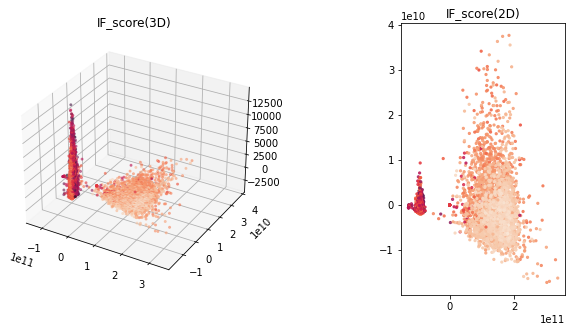

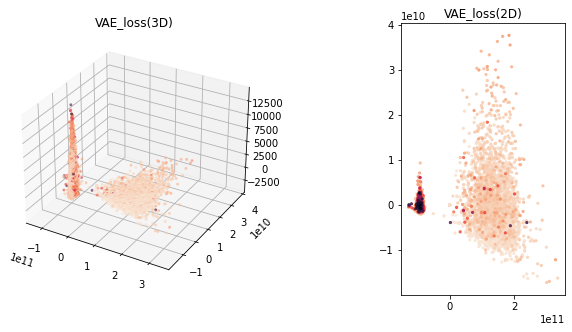

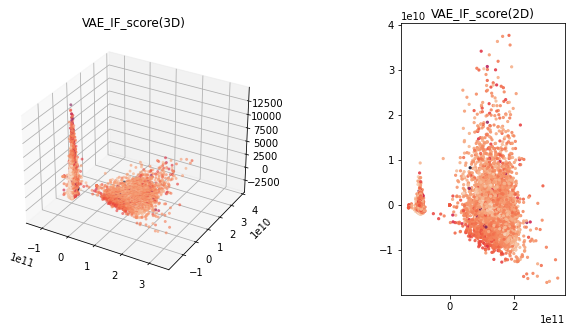

In [105]:
# we keep 99% quantile value in `VAE_loss` since there are very extreme value
drop_extremes = [0, 0.01, 0] 

for metric,drop_extreme in zip(metrics,drop_extremes):
    anomaly_visualization(df.drop(metrics,axis=1),df[metric],metric,drop_extreme)

In the above figure, we compressed the original 20-dimensional data to 2~3 dimensions respectively for visualization. Where the darker color indicates the higher possibility of anomaly. It can be seen that.
- **Isolation Forest** is good at finding out the data edges as well as very small clusters.
- **VAE** is very sensitive to clustering who is far away from majority
- **VAE+IF**: the difference in values is relatively small, but we can still find some points at the edges where the possibility of anomalies is high

## 5.2 Association of the three indicators

In [22]:
df_matrics = df[metrics]
df_matrics.head()

,IF_score,VAE_loss,VAE_IF_score
0,0.502624,1.038172,0.498682
1,0.495589,0.998328,0.490106
2,0.533843,1.940183,0.546778
3,0.522155,0.473524,0.550927
4,0.495372,0.595858,0.516590


In [70]:
import matplotlib.pyplot as plt 


plt.axhline
def matrics_vistualization(df_matrics):
    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.scatter(df_matrics['IF_score'],df_matrics['VAE_IF_score'],
                s=8,alpha=0.9,c=df_matrics['VAE_loss'],cmap="rocket_r")
    ax.axvline(df_matrics['IF_score'].quantile(0.95),
               c='black',ls='--',alpha=0.5, label="95% quantile")
    ax.axhline(df_matrics['VAE_IF_score'].quantile(0.95),
               c='black',ls='--',alpha=0.5)
    ax.set_xlabel('IF_score')
    ax.set_ylabel('VAE_IF_score')
    ax.set_title('Matrics of 3 different models \n' + 'color indicates `VAE_loss` (the deeper the higher)')
    plt.legend()
    plt.show()

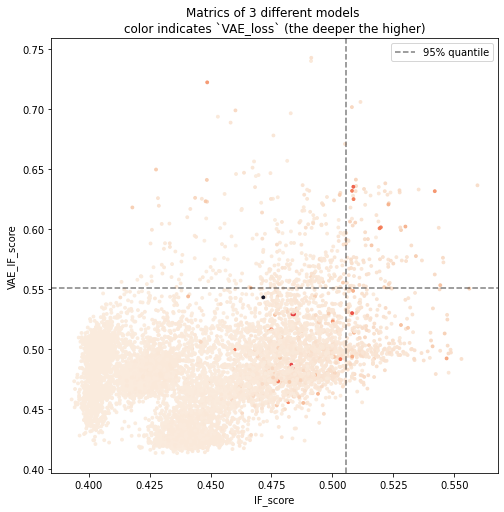

In [71]:
matrics_vistualization(df_matrics)

It can be seen that：
1. In the lower left corner of the image ( x∈[0, 0.45] and y∈[0, 0.55] )
    the values of all three indicators are low, which means that it is less likely to be an outlier
    
2. In the upper part of the image (y>0.6) as well as in the right part (x>0.525), the value of `VAE_loss` seems to be higher, but it is not significant.
    But when both `IF_score` and `VAE_IF_score` have higher scores, `VAE_loss` also tends to have higher values (i.e., all three metrics are considered more likely to be anomalous)
    
3. x∈[0.46, 0.52] and y∈[0.45, 0.55]
    At the edge of this region, `VAE_IF_loss` indicates some outliers, but for the other two indicators, the same conclusion is not always reached